In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib import animation
import cv2
import scipy
import h5py

In [2]:
# angular spectrum method
# input: 
#   complex wavefront -> will try to use polar form: Ae^(j\phi) at input plane
#   distance to propagate
#   planes assumed to be of the same size with same sampling and paralled to each other
# output: complex wavefront at the output plane

In [3]:
# idea: propogration from sensor plane to object plane
# discretize the object plane (same as the resolution of the sensor with same support)
# find spectrum on the sensor plane given the complex wavefront
# find z % 2\pi for each wavefront along its angle?
# add phase to each wave
# Tadaa: you have wavefront on the object plane

# look out for
# wave wrapping due to fourier
# increase spatial support artificially by padding 0 on both planes such that you have o phase wrapping
# crop after inverse fourier to get rid of excess space

# important
# everything has to relate to physical units
# dimensions and resolution of the camera
# max/nyqust spatial frequency relates to physical dimensions

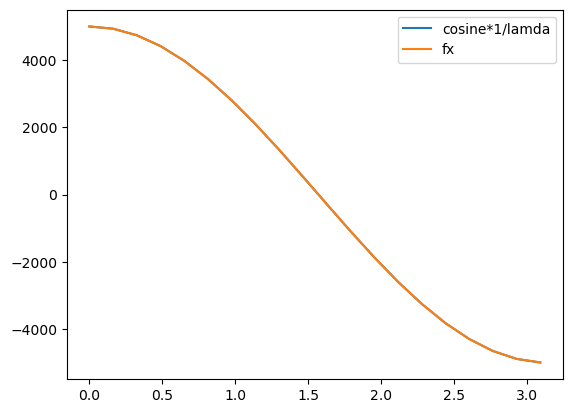

In [4]:
# relating angle with frequency along one axis

theta = np.linspace(0, np.pi - 1/20, 20)

plt.plot(theta, np.cos(theta)*5000, label="cosine*1/lamda")
lamda = 0.2*1e-3
plt.plot(theta, np.cos(theta)/lamda, label="fx")
plt.legend()

In [7]:
np.cos(np.pi/180*30)

0.8660254037844387

In [8]:
np.arccos(650*1e-9 * 1/(0.002*1e-3)/2)*180/np.pi

80.64796494243684

In [9]:
1/(0.02*1e-3)/2

24999.999999999996

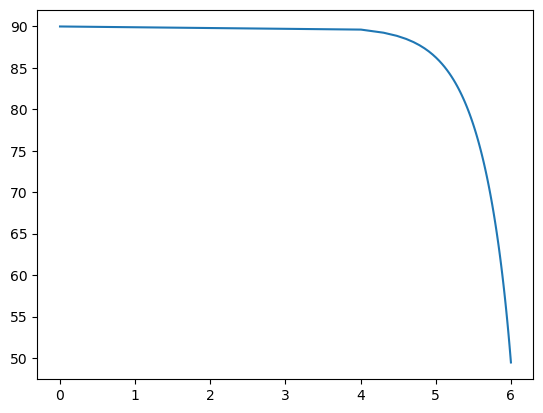

In [10]:
fx = np.linspace(1, 1e6, 100)
thetax = np.arccos(650*1e-9 * fx)*180/np.pi

plt.plot(np.log10(fx), thetax)

In [11]:
lamda = 650*1e-9

alpha = np.pi/4
beta = np.pi/2
gamma = np.arccos(np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2))

x = np.linspace(-1e-4, 1e-4, 1000)
y = np.linspace(-1e-4, 1e-4, 1000)
X, Y = np.meshgrid(x, y)
z = 0.3

mono_wave = 1*np.exp((1j*2*np.pi/lamda)*(np.cos(alpha)*X + np.cos(beta)*Y))*np.exp((1j*2*np.pi/lamda)*(np.cos(gamma)*z))

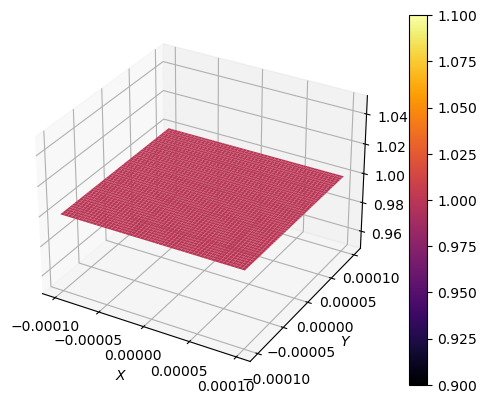

In [12]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')


ax3d.set_xlabel(r'$X$')
ax3d.set_ylabel(r'$Y$')
ax3d.set_zlabel(r'$Amplitude$')

surf = ax3d.plot_surface(X, Y, np.abs(mono_wave), cmap=cm.inferno)
fig.colorbar(surf)

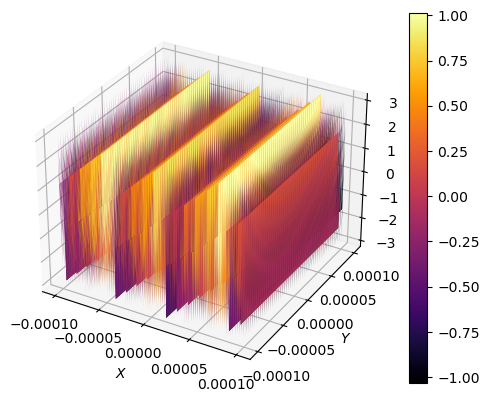

In [13]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')


ax3d.set_xlabel(r'$X$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$Y$')  # phi -> phase
ax3d.set_zlabel(r'$Phase$')   # signal amplitude

surf = ax3d.plot_surface(X, Y, np.angle(mono_wave), cmap=cm.inferno)
fig.colorbar(surf)

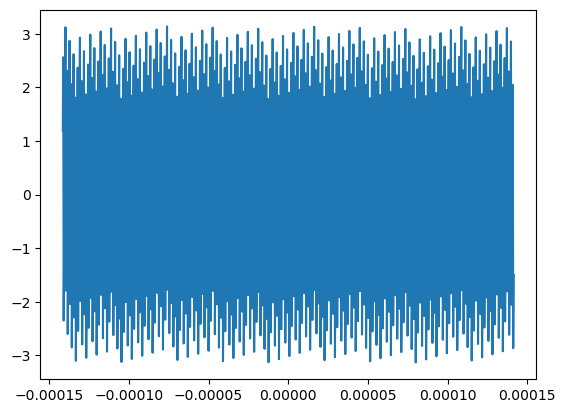

In [14]:
plt.plot(np.linspace(-np.sqrt(0.0001**2 + 0.0001**2), np.sqrt(0.0001**2 + 0.0001**2), 1000), np.angle(mono_wave).diagonal())

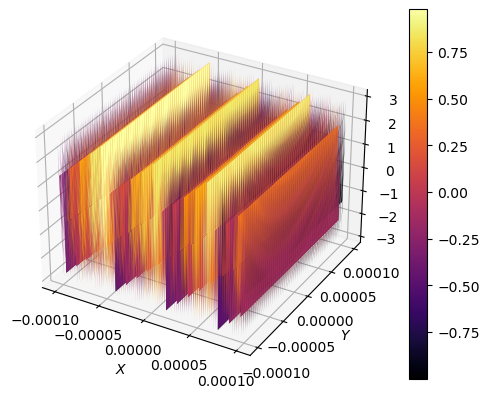

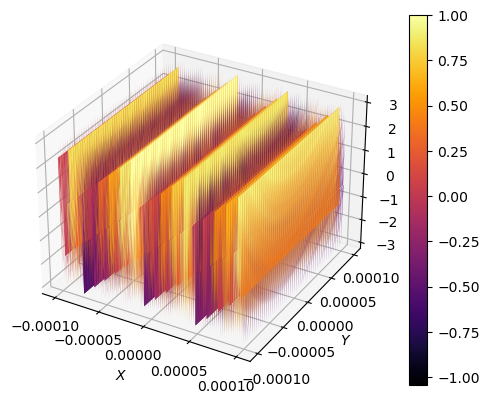

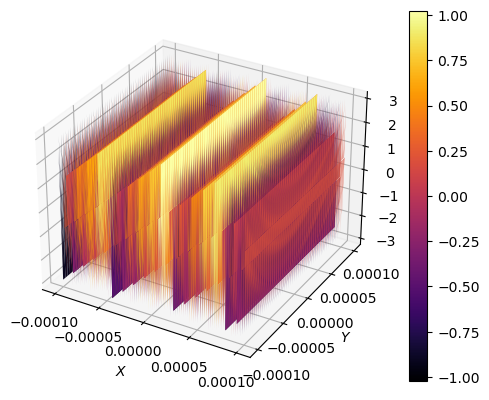

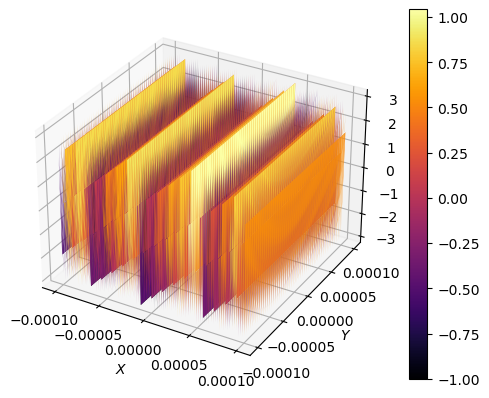

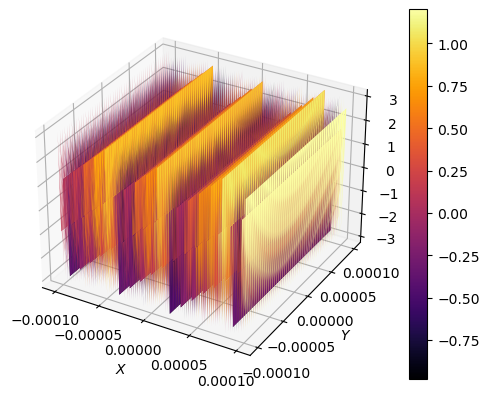

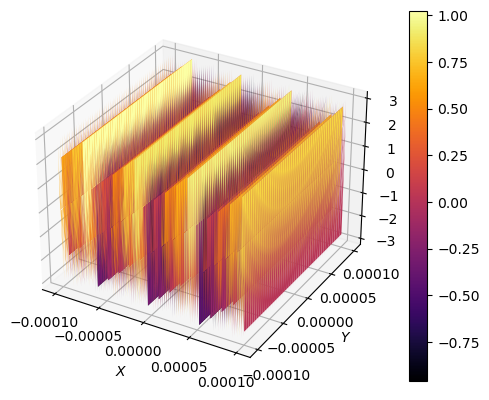

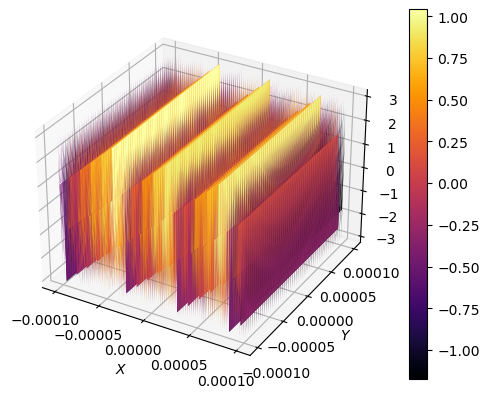

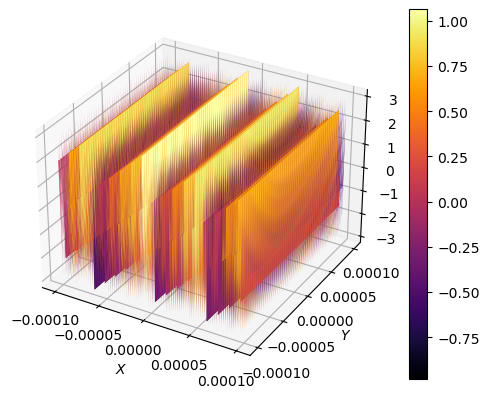

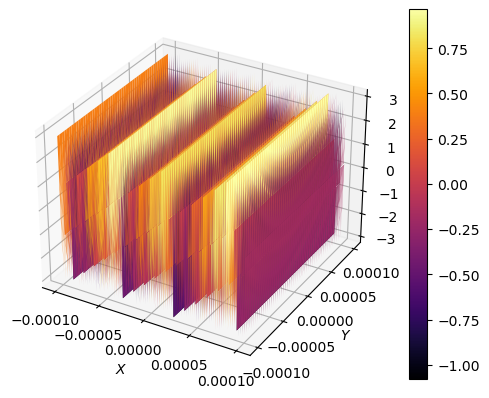

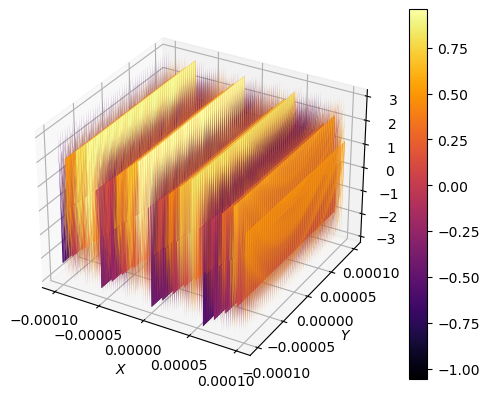

In [15]:


for z in np.linspace(0, 2*650*1e-9, 10):
    fig = plt.figure()
    ax3d = fig.add_subplot(111, projection='3d')
    ax3d.set_xlabel(r'$X$')  # tau = omega*t -> adimensional time
    ax3d.set_ylabel(r'$Y$')  # phi -> phase
    ax3d.set_zlabel(r'$Phase$')   # signal amplitude
    mono_wave = 1*np.exp((1j*2*np.pi/lamda)*(np.cos(alpha)*X + np.cos(beta)*Y))*np.exp((1j*2*np.pi/lamda)*(np.cos(gamma)*z))
    surf = ax3d.plot_surface(X, Y, np.angle(mono_wave), cmap=cm.inferno)
    fig.colorbar(surf)
    plt.show()

In [318]:
# calculate max frequency

mm = 1e-3

wl = 658*1e-6*mm
z = -200*mm

numPxX = 1392
numPxY = 1040
sizePx = 0.00645*mm
sizePy = 0.00645*mm
sizeSensorX = numPxX*sizePx
sizeSensorY = numPxY*sizePy

# sampling plane 2x for linearization.
Sx = 2*sizeSensorX
Sy = 2*sizeSensorY

samplingRate = 1/sizePx
# maxFreqY = 1/sizePy

maxFreqPossible = samplingRate/2
maxAnglePossible = samplingRate*wl # cosine

maxAngleSetupX = sizeSensorX/(2*np.linalg.norm([z, sizeSensorX])) # cosine \thetaX
maxAngleSetupY = sizeSensorY/(2*np.linalg.norm([z, sizeSensorY])) # cosing \thetaY

maxFreqSetupX = maxAngleSetupX/wl
maxFreqSetupY = maxAngleSetupY/wl

In [319]:
Sx/mm, Sy/mm, samplingRate/1e3

(17.9568, 13.416, 155.03875968992247)

In [320]:
maxFreqSetupX, maxFreqSetupY, maxFreqPossible

## problematic? given camera's pixel size, we can calculate the 
## max freq the camera can capture without aliasisng. This freq
## is much smaller than the max freq, given the wavelength and 
## the max angle, our observed image should be aliased.
## alright now.

(34078.14059295937, 25471.99908710085, 77519.37984496124)

In [306]:
# max freq to prevent aliasing by the transfer function

delU = 1/Sx
uLimit = 1/(np.sqrt((2*delU*z)**2 + 1)* wl)

delV = 1/Sy
vLimit = 1/(np.sqrt((2*delV*z)**2 + 1)* wl)

In [307]:
uLimit, vLimit

## if uLimit and vLimit > maxFreqSetupX and maxFreqSetupY,
## then the limitations of the transfer function does not
## cause diffraction? of our signal.

(1510417.2365080903, 1503145.9823827576)

In [308]:
# img = np.random.rand(int(sizeSensorX/sizePx), int(sizeSensorY/sizePx))
# img = cv2.imread("2024_01_30_Wolfgangs_Wavefront_Sensor_First_Test/01_with_object.tif", cv2.IMREAD_UNCHANGED)
img = np.array(h5py.File('Reconstruction/02_02.mat', 'r').get('A'))*np.exp(1j*np.array(h5py.File('Reconstruction/05_02.mat', 'r').get('phi')))
img = img.T
linImg = np.zeros([int(Sy/sizePx), int(Sx/sizePx)], dtype=np.complex128)
linImg[int(linImg.shape[0]/2 - img.shape[0]/2):int(linImg.shape[0]/2 + img.shape[0]/2), 
       int(linImg.shape[1]/2 - img.shape[1]/2):int(linImg.shape[1]/2 + img.shape[1]/2)] = img

In [325]:
list(img.shape)

[1040, 1392]

C:\Users\Kazim\AppData\Local\Temp\ipykernel_11964\4249486754.py:2: RuntimeWarning: divide by zero encountered in log10
  cp_amp = axs[0].imshow(np.log10(np.abs(linImg)), cmap='gray')


((2080, 2784), (1040, 1392), dtype('complex128'))

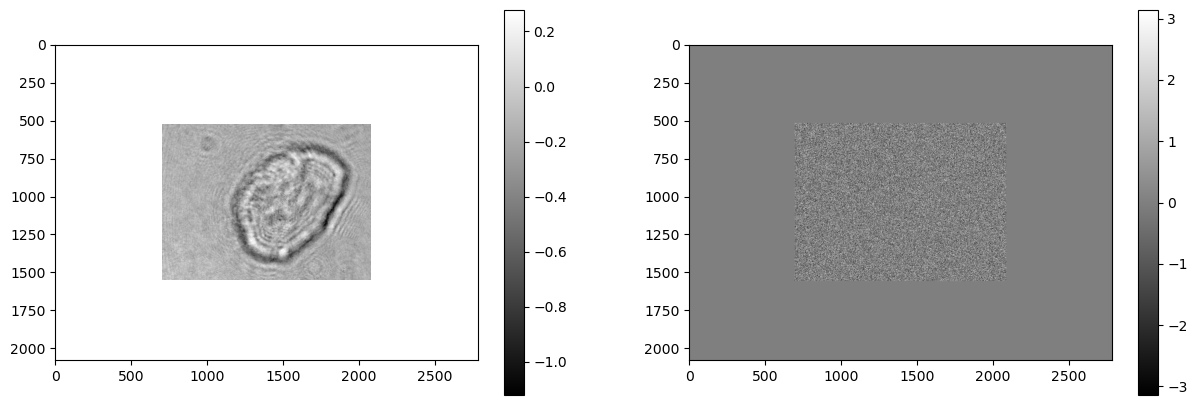

In [309]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
cp_amp = axs[0].imshow(np.log10(np.abs(linImg)), cmap='gray')
cp_ang = axs[1].imshow(np.angle(linImg), cmap='gray')

fig.colorbar(cp_amp, ax=axs[0])
fig.colorbar(cp_ang, ax=axs[1])

linImg.shape, img.shape, linImg.dtype

In [310]:
freqRows = np.linspace(-1/(2*sizePx), 1/(2*sizePx), int(1/(sizePx*delU))) ## -maxFreq/2, +maxFreq/2
freqCols = np.linspace(-1/(2*sizePx), 1/(2*sizePx), int(1/(sizePx*delV)))

freqPlane = np.meshgrid(freqRows, freqCols)
np.array(freqPlane, dtype=np.int16).shape

(2, 2080, 2784)

In [311]:
# transfer function
# condition for evanascent waves? does not necessary

freqRows = np.linspace(-1/(2*sizePx), 1/(2*sizePx), int(1/(sizePx*delU))) ## -maxFreq/2, +maxFreq/2
freqCols = np.linspace(-1/(2*sizePx), 1/(2*sizePx), int(1/(sizePx*delV)))

u, v = np.meshgrid(freqRows, freqCols)
w = np.sqrt(wl**(-2) - u**2 - v**2)

H = np.exp(1j*2*np.pi*w*z)

# limiting frequencies above uLimit and vLimit of the transfer function
mask = np.ones_like(H)
mask[np.logical_or(np.abs(u) > int(uLimit), np.abs(v) >= int(vLimit))] = 0

H = mask*H

In [312]:
freqVals_0 = np.fft.fftshift(np.fft.fft2(linImg))
freqVals_z = H*freqVals_0
u_z = np.fft.ifft2(np.fft.fftshift(freqVals_z))
u_z = u_z[int(linImg.shape[0]/2 - img.shape[0]/2):int(linImg.shape[0]/2 + img.shape[0]/2),
          int(linImg.shape[1]/2 - img.shape[1]/2):int(linImg.shape[1]/2 + img.shape[1]/2)]

In [326]:
H.shape

(2080, 2784)

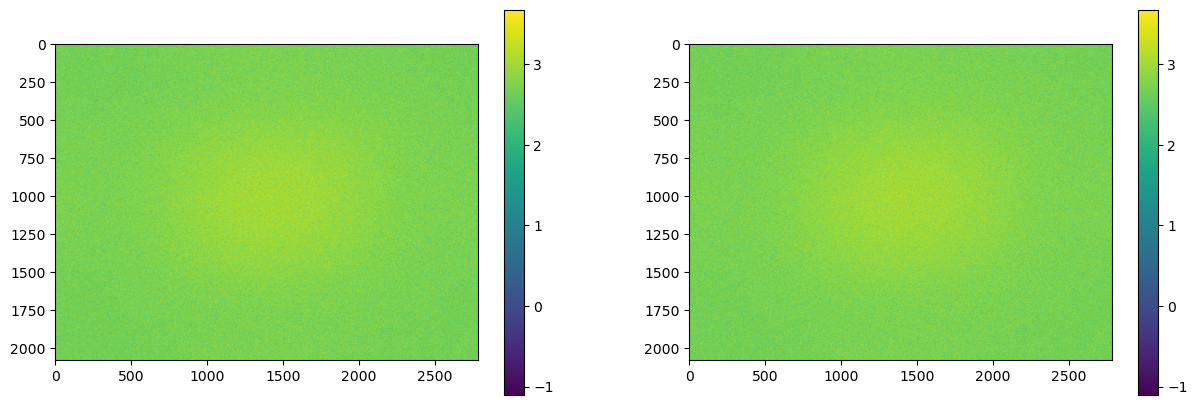

In [313]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cp_freq_0 = axs[0].imshow(np.log10(np.abs(freqVals_0)))
cp_freq_z = axs[1].imshow(np.log10(np.abs(freqVals_z)))

fig.colorbar(cp_freq_0, ax=axs[0])
fig.colorbar(cp_freq_z, ax=axs[1])

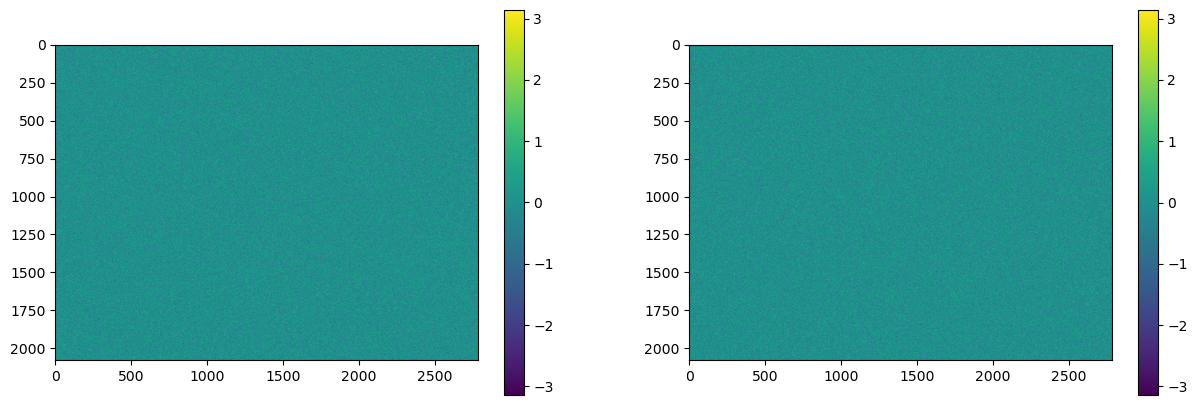

In [314]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cp_freq_0_ang = axs[0].imshow(np.angle(freqVals_0))
cp_freq_z_ang = axs[1].imshow(np.angle(freqVals_z))

fig.colorbar(cp_freq_0_ang, ax=axs[0])
fig.colorbar(cp_freq_z_ang, ax=axs[1])

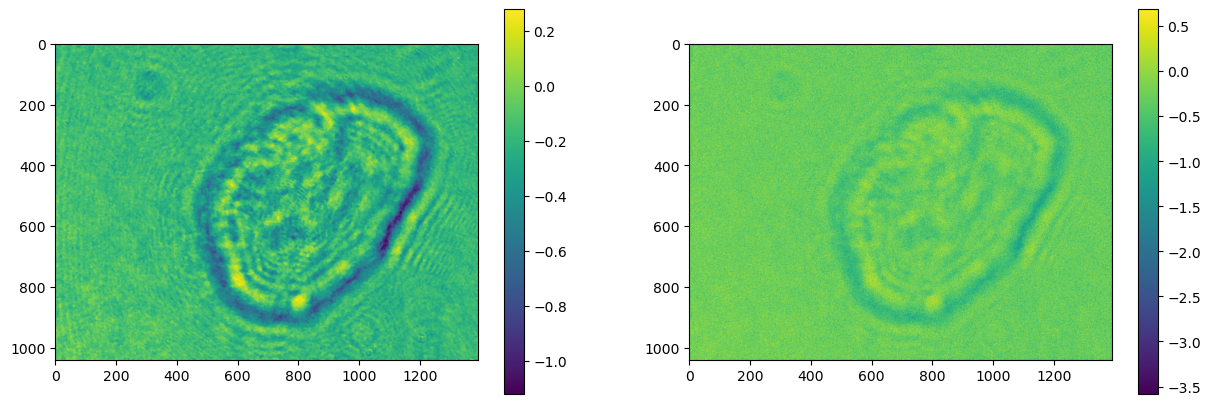

In [315]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cp_img_0_amp = axs[0].imshow(np.log10(np.abs(img)))
cp_img_z_amp = axs[1].imshow((np.log10(np.abs(u_z))))

fig.colorbar(cp_img_0_amp, ax=axs[0])
fig.colorbar(cp_img_z_amp, ax=axs[1])

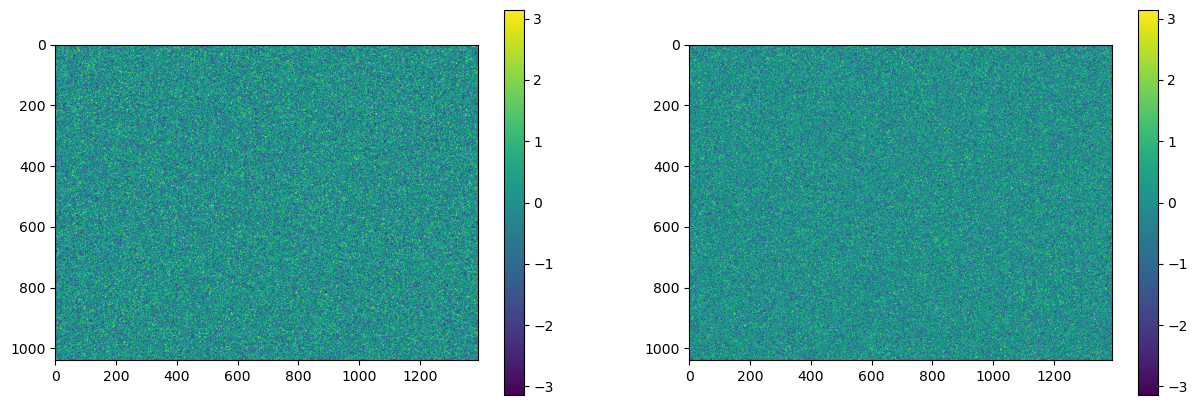

In [316]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cp_img_0_ang = axs[0].imshow(np.angle(img))
cp_img_z_ang = axs[1].imshow(np.angle(u_z))

fig.colorbar(cp_img_0_ang, ax=axs[0])
fig.colorbar(cp_img_z_ang, ax=axs[1])

In [317]:
freqPos = np.fft.fftshift(np.fft.fftfreq(linImg.shape[0], d=sizePx))
freqPos

array([-77519.37984496, -77444.84197973, -77370.30411449, ...,
        77295.76624925,  77370.30411449,  77444.84197973])